# Statistical Analysis of Time Series Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import KernelPCA

from yf_helpers import yf_downloader
from yf_helpers import yf_reader

In [2]:
start = "2023-01-01"
end = "2023-12-31"

dj = yf_reader("data/DowJones-20141106-20241106.csv", start, end)
dj.tail()

,date,symbol,adjusted,close,high,low,open,volume
67958,2023-12-29,TRV,187.869812,190.490005,190.820007,188.809998,189.339996,1048500.0
67959,2023-12-29,UNH,520.342346,526.469971,528.239990,523.919983,525.979980,2080100.0
67960,2023-12-29,V,258.866302,260.350006,261.459991,259.670013,260.570007,4074600.0
67961,2023-12-29,VZ,35.344772,37.700001,37.759998,37.320000,37.380001,16205200.0
67962,2023-12-29,WMT,52.042637,52.549999,52.693333,52.386665,52.509998,21948300.0


## Kernel Principal Component Analysis

In [3]:
daily_components = dj.pivot_table(
    index="date", columns="symbol", values="close"
).asfreq("D", method="ffill")

In [4]:
daily_components.shape

(361, 30)

### Finding Eigenvectors and Eigenvalues

In [5]:
def fn_z_score(x):
    return (x - x.mean()) / x.std()

In [6]:
df_z_components = daily_components.apply(fn_z_score)
fitted_pca = KernelPCA().fit(df_z_components)

[Text(0, 0.5, 'eigenvalues')]

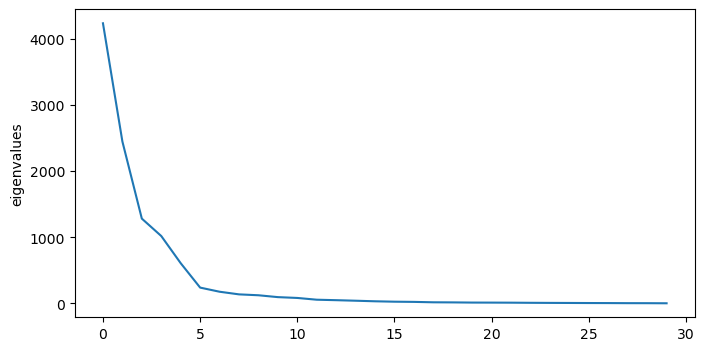

In [7]:
_, ax = plt.subplots(figsize=(8, 4))

ax.plot(fitted_pca.eigenvalues_)
ax.set(ylabel="eigenvalues")

In [8]:
def fn_weighted_avg(x):
    return x / x.sum()


weighted_values = fn_weighted_avg(fitted_pca.eigenvalues_)[:5]
print(weighted_values)

[0.39242311 0.22679801 0.11880792 0.09441715 0.05635573]


In [9]:
weighted_values.sum()

0.8888019127329738

### Reconstructing the Dow Index with PCA

In [10]:
kernel_pca = KernelPCA(n_components=5).fit(df_z_components)
pca_5 = kernel_pca.transform(df_z_components)

weights = fn_weighted_avg(kernel_pca.eigenvalues_)
reconstructed_values = np.dot(pca_5, weights)

In [11]:
yf_downloader("AAPL", start="2014-11-06", end="2024-11-06")

Data already exists


'data/AAPL-20141106-20241106.csv'

In [12]:
aapl = yf_reader("data/AAPL-20141106-20241106.csv", start, end)
aapl.tail()

,date,symbol,adjusted,close,high,low,open,volume
2297,2023-12-22,AAPL,192.868134,193.600006,195.410004,192.970001,195.179993,37122800.0
2298,2023-12-26,AAPL,192.320221,193.050003,193.889999,192.830002,193.610001,28919300.0
2299,2023-12-27,AAPL,192.419830,193.149994,193.500000,191.089996,192.490005,48087700.0
2300,2023-12-28,AAPL,192.848221,193.580002,194.660004,193.169998,194.139999,34049900.0
2301,2023-12-29,AAPL,191.802185,192.529999,194.399994,191.729996,193.899994,42628800.0


In [13]:
daily_components2 = aapl.pivot_table(
    index="date", columns="symbol", values="close"
).asfreq("D", method="ffill")

<Axes: xlabel='date'>

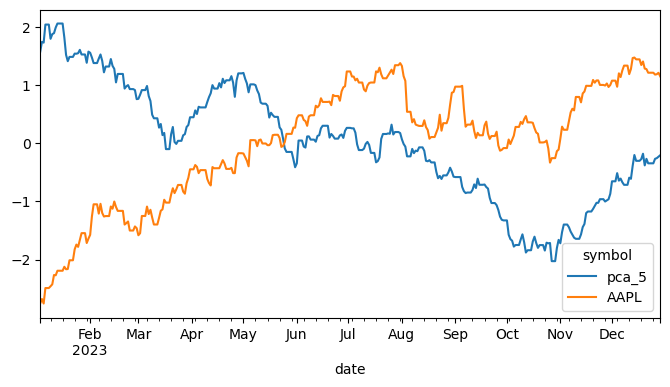

In [14]:
# Combine TSLA and PCA index for comparison
df_combined = daily_components2.copy()
df_combined["pca_5"] = reconstructed_values
df_combined = df_combined.apply(fn_z_score)

_, ax = plt.subplots(figsize=(8, 4))
df_combined.plot(y=["pca_5", "AAPL"], ax=ax)